# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

--2024-01-17 15:25:34--  https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233926 (228K) [image/png]
Saving to: 'dom.png'

     0K .......... .......... .......... .......... .......... 21% 2,46M 0s
    50K .......... .......... .......... .......... .......... 43% 6,13M 0s
   100K .......... .......... .......... .......... .......... 65% 2,98M 0s
   150K .......... .......... .......... .......... .......... 87% 8,85M 0s
   200K .......... .......... ........                        100% 13,4M=0,05s

2024-01-17 15:25:35 (4,31 MB/s) - 'dom.png' saved [233926/233926]



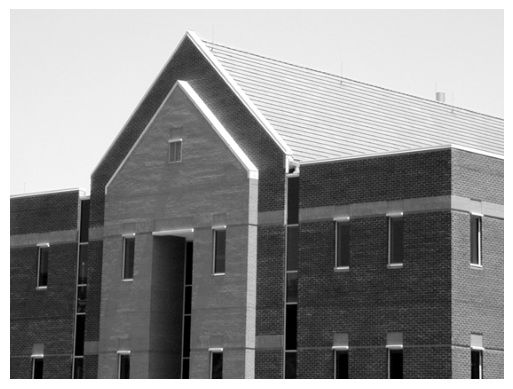

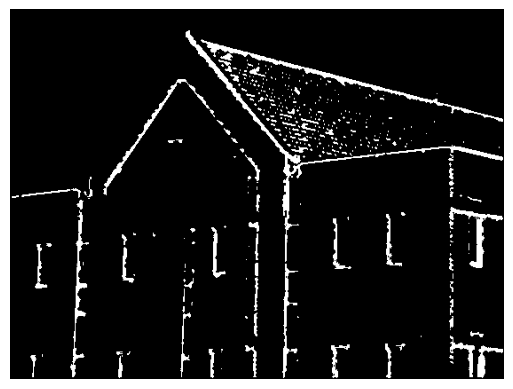

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate

dom = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(dom, 'gray')
plt.axis('off')
plt.show()

def crossing(LoG, threshold):
    x, y = LoG.shape
    result = np.ones((x, y)) * 255

    for i in range(1, x - 1):
        for j in range(1, y - 1):
            surrounding = LoG[i - 1: i + 2, j - 1: j + 2]
            maximum = np.max(surrounding)
            minimum = np.min(surrounding)

            if minimum * maximum < 0:
                if LoG[i, j] > 0:
                    result[i, j] += np.abs(maximum)

                else:
                    result[i, j] += np.abs(minimum)

    result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX)
    result_thresholding = result > threshold
    result = result_thresholding.astype(np.uint8) * 255
    result = cv2.medianBlur(result, 3)

    return result

gauss_I_dom = cv2.GaussianBlur(dom, (5, 5), 1)
laplace_I_dom = cv2.Laplacian(gauss_I_dom, cv2.CV_32F)

crossing_I_dom = crossing(laplace_I_dom, 70)

plt.imshow(crossing_I_dom, 'gray')
plt.axis('off')
plt.show()

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj pierwszą część algorytmu detekcji krawędzi Canny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
7. Na jednym obrazie zaznacz piksele należące do obrazu $g_{NH}$ jako czerwone oraz należące do obrazu $g_{NL}$ jako niebieskie.
Wyświetl obraz.

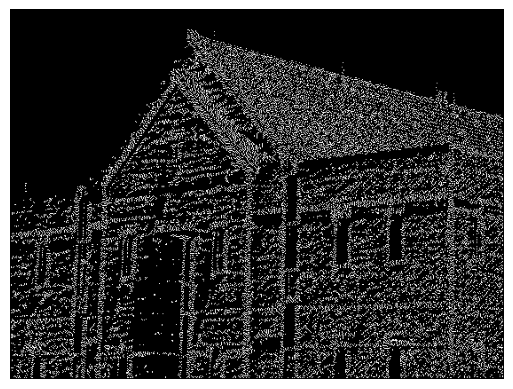

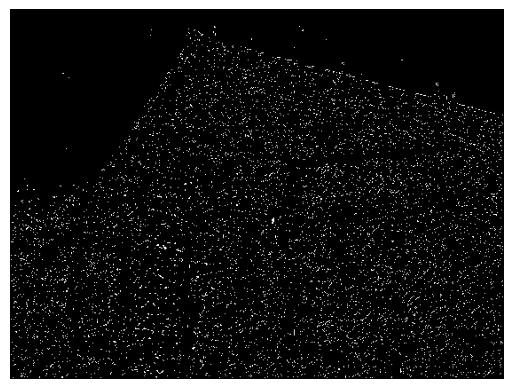

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


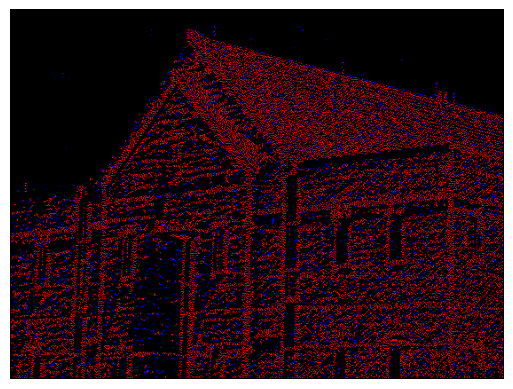

In [2]:
def canny(img, th, tl):
    X, Y = img.shape
    img_blur = cv2.GaussianBlur(img ,(5, 5), 0)
    S1=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    S2=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    Gx=cv2.filter2D(img_blur, -1, S1)
    Gy=cv2.filter2D(img_blur, -1, S2)
    ampli = np.sqrt(Gx**2 + Gy**2)
    alfa = np.arctan2(Gx, Gy)
    alfa_deg = alfa * 180/np.pi
    alfa_deg[alfa_deg < 0] += 180
    kier = np.zeros((X, Y))

    for i in range(X):
        for j in range(Y):
            if (0 <= alfa_deg[i,j] < 22.5) or (157.5 <= alfa_deg[i,j] <= 180):
                kier[i,j]=1
            elif (22.5 <= alfa_deg[i,j] < 67.5):
                kier[i,j]=2
            elif (67.5 <= alfa_deg[i,j] < 112.5):
                kier[i,j]=3
            elif (112.5 <= alfa_deg[i,j] < 157.5):
                kier[i,j]=4
    gn = nonmax(kier, ampli)
    gnh = gn >= th
    gnl=np.where(np.logical_and(th > gn, gn >= tl), 1, 0)
    return gnh, gnl

def nonmax(kier,ampli):
    X, Y = kier.shape
    gn = np.zeros((X, Y))

    for i in range (1, X - 1):
        for j in range (1, Y - 1):
            if kier[i, j] == 1:
                if ampli[i, j - 1] > ampli[i, j] or ampli[i, j + 1] > ampli[i, j]:
                    gn[i, j] = 0
                else:
                    gn[i, j] = ampli[i, j]
            elif kier[i, j] == 2:
                if ampli[i + 1, j - 1] > ampli[i, j] or ampli[i - 1, j + 1] > ampli[i, j]:
                    gn[i, j] = 0
                else:
                    gn[i, j] = ampli[i, j]
            elif kier[i, j] == 3:
                if ampli[i + 1, j] > ampli[i, j] or ampli[i - 1, j] > ampli [i, j]:
                    gn[i,j] = 0
                else:
                    gn[i, j] = ampli[i, j]
            elif kier[i, j] == 4:
                if ampli[i - 1, j - 1] > ampli[i, j] or ampli[i + 1, j + 1] > ampli[i, j]:
                    gn[i, j] = 0
                else:
                    gn[i, j] = ampli[i, j]
    return gn

gnh, gnl = canny(dom, tl = 5, th = 10)

plt.imshow(gnh, 'gray', vmin = 0, vmax = 1)
plt.axis('off')
plt.show()

plt.imshow(gnl, 'gray', vmin = 0, vmax = 1)
plt.axis('off')
plt.show()

X,Y = gnh.shape
obraz = np.zeros((X,Y,3))
for i in range (0, X):
    for j in range (0, Y):
        if gnh[i, j] == 1:
            obraz[i, j] = [255, 0, 0]
        elif gnl[i, j] == 1:
            obraz[i, j] = [0, 0, 255]
plt.imshow(obraz)
plt.axis('off')
plt.show()

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z wykonaną częściową implementacją w poprzednim ćwiczeniu.
Na czym polegają różnice?

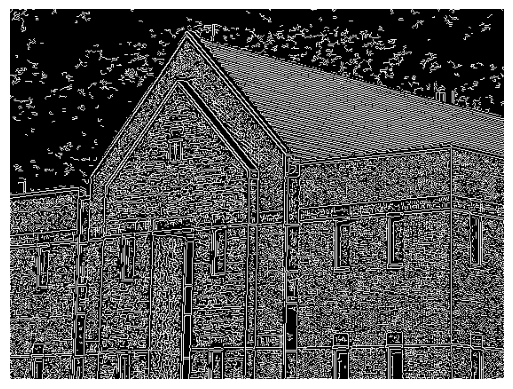

In [3]:
img_canny=cv2.Canny(dom, 5, 10, None, 3, 1)
plt.imshow(img_canny, 'gray')
plt.axis('off')
plt.show()